# **Trabalho \#3**:  Aprendizado de Máquina e Reconhecimento de Padrões MC886/MO444
Instituto de Computação (IC/UNICAMP), 2ᵒ Semestre, 2024

Profa. Sandra Avila, 2024s2

Trabalho proposto por Caio Petrucci Rosa (PAD), Cesar Guedes Carneiro (PED) e Sandra Avila.



In [3]:
print('RA: 217787', 'Bruno Sobreira França')
print('RA: 169374', 'Daniel Paulo Garcia')

RA: 217787 Bruno Sobreira França
RA: 169374 Daniel Paulo Garcia


## Objetivo

Explore **redes neurais** e desenvolva o melhor modelo possível para o problema, evitando *overfitting*. Em particular, construa um sistema de reconhecimento de objetos para classificar imagens usando a base de dados OrganCMNIST.

Nesta atividade, você não tem permissão para usar frameworks de redes neurais (por exemplo, Pytorch, Tensorflow, Keras), exceto funções básicas, como Dataloaders, que já estão especificadas nas células de código. Você deve implementar os métodos necessários usando NumPy. Além disso, você pode usar scikit-learn (ou bibliotecas similares) para calcular métricas de avaliação, e todas as bibliotecas de plotagem de gráficos também são permitidas.

Criamos uma verificação de integridade (*sanity check*, teste de sanidade) para todos os métodos que você precisa implementar, para que você possa verificar se o comportamento geral do seu algoritmo está correto. No entanto, isso não garante que sua implementação esteja correta, já que, infelizmente, depurar modelos de redes neurais não é uma tarefa simples.

---

## Prazo

**Prazo de entrega:** 06 de Novembro, quarta-feira, 23:59.

**Política de penalidades por envio atrasado:** Você não está sendo encorajada(o) a submeter o trabalho após a data de submissão. Entretanto, caso isso aconteça, a nota será penalizada da seguinte forma:
- 07 de Novembro, 23:59: nota * 0,75
- 08 de Novembro, 23:59: nota * 0,5
- 09 de Novembro, 23:59: nota * 0,25

## Envio

No Google Classroom, envie seu Jupyter Notebook, no formato `RA1_RA2_2024s2_mc886mo444_trabalho_03.ipynb`.

**Esta atividade NÃO é individual, deve ser realizada em dupla (grupo de duas pessoas).**

---

## 1. Base de Dados

O OrganCMNIST é um dos conjuntos de dados de imagem do [MedMNIST](https://medmnist.com/), derivado de imagens de tomografia computadorizada (CT) 3D do *Liver Tumor Segmentation Benchmark* (LiTS). O conjunto de dados contém fatias 2D recortadas das vistas coronais das imagens 3D originais, focando em 11 órgãos do corpo. As anotações de caixas delimitadoras (*bounding boxes*) de um estudo separado são usadas para obter os rótulos dos órgãos. As Unidades Hounsfield (HU) das tomografias são transformadas em tons de cinza utilizando uma janela abdominal, e cada imagem é redimensionada para 1x28x28 pixels para facilitar a classificação multi-classe.

O OrganCMNIST inclui um total de 23.583 imagens organizadas em 11 classes. O conjunto de dados é dividido em:
* 12.975 exemplos de treinamento,
* 2.392 exemplos de validação, e
* 8.216 exemplos de teste.

Cada exemplo é uma imagem em escala de cinza (1x28x28) associada a um rótulo de uma das 11 classes de órgãos.

Cada exemplo é atribuído a um dos seguintes rótulos:

| ID da Classe | Órgão | # Imagens | % |
|:---:|:---|---:|---:|
| 0 | bladder (bexiga) | 2167 | 9,19 |
| 1 | femur-left (fêmur-esquerdo) | 1152 | 4,88 |
| 2 | femur-right (fêmur-direito) | 1112 | 4,72 |
| 3 | heart (coração) | 1223 | 5,19 |
| 4 | kidney-left (rim-esquerdo) | 1947 | 8,26 |
| 5 | kidney-right (rim-direito) | 2062 | 8,74 |
| 6 | liver (fígado) | 5250 | 22,26 |
| 7 | lung-left (pulmão-esquerdo) | 1898 | 8,05 |
| 8 | lung-right (pulmão-direito) | 1931 | 8,19 |
| 9 | pancreas (pâncreas) | 2102 | 8,91 |
| 10 | spleen (baço) | 2739 | 11,61 |

Esta base de dados oferece uma representação simplificada dos órgãos abdominais, tornando-o adequado para tarefas de classificação multi-classe em pesquisas de imagens médicas.

#### **Informações sobre a base de dados**

- Os dados estão disponíveis no Google Sala de Aula (Classroom) junto a atividade.
- Você deve respeitar a divisão de treino/validação/teste disponibilizada no Google Sala de Aula (Classroom). Evite *overfitting*.
- Você deve avaliar os modelos usando **balanced accuracy** ou **AUC**. Utilizaremos a **balanced accuracy** na submissão do Kaggle.

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, log_loss, balanced_accuracy_score
from typing import List
from abc import ABC, abstractmethod
from torch.utils.data import Dataset, DataLoader
import torch

import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [5]:
# prepara os dados usando o Dataloader do Pytorch

class OrganCMNIST(Dataset):
    def __init__(self, x, y=None, transform=None):
        self._x = x
        self._y = y.squeeze() if y is not None else None
        self._transform = transform
        self._num_classes = 11

    def __len__(self):
        return self._x.shape[0]

    def __getitem__(self, idx):
        image = self._x[idx]
        if self._transform is not None:
            image = self._transform(image)

        image = image.flatten()
        if self._y is None:
            return image

        # one hot encoding
        label = [0] * self._num_classes
        label[self._y[idx]] = 1
        return image, torch.Tensor(label)

In [6]:
# um exemplo de uma função de normalização, você pode implementar outra caso ache necessário

def normalize(X):
    return (X - X.mean())/(X.std() + 1e-8)

def z_score_normalize(X):
  return (X - X.mean()) / (X.std(ddof=1) + 1e-8)

def minmax_normalize(X):
  return (X - X.min()) / (X.max() - X.min())


#### **Carregando os dados**

In [7]:
!gdown --id 1zsFb80QunJtF2BkPf5rMZu5tOHBVt2-4

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zsFb80QunJtF2BkPf5rMZu5tOHBVt2-4
To: /content/data.npz
100% 15.5M/15.5M [00:00<00:00, 44.8MB/s]


In [8]:
# defina o caminho para o dataset adequadamente
dataset_path = 'data.npz'
organcmnist = np.load(dataset_path)

x_train, y_train = organcmnist['train_images'], organcmnist['train_labels']
x_val, y_val = organcmnist['val_images'], organcmnist['val_labels']

# você não terá acesso à label do conjunto de teste
x_test = organcmnist['test_images']

In [9]:
train_set = OrganCMNIST(x_train, y_train, transform=normalize)
val_set = OrganCMNIST(x_val, y_val, transform=normalize)
test_set = OrganCMNIST(x_test, transform=normalize)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

## Análise exploratoira dos dados

In [10]:
'''
  Quantidade de dados de treino, validação dos testes
'''
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape

((12970, 28, 28), (12970, 1), (5306, 28, 28), (5306, 1), (5307, 28, 28))

In [11]:
'''
  Essa celula nós dá uma noção de quão balanceado as classes estão
'''

def count_values_per_classe(ndarray):
  unique_values, counts = np.unique(ndarray, return_counts=True)
  for value, count in zip(unique_values, counts):
      print(f"Classe: {value} | Quantidade: {count}")

print('Treino')
count_values_per_classe(y_train)
print('Validação')
count_values_per_classe(y_val)

Treino
Classe: 0 | Quantidade: 1192
Classe: 1 | Quantidade: 633
Classe: 2 | Quantidade: 612
Classe: 3 | Quantidade: 673
Classe: 4 | Quantidade: 1071
Classe: 5 | Quantidade: 1134
Classe: 6 | Quantidade: 2887
Classe: 7 | Quantidade: 1044
Classe: 8 | Quantidade: 1062
Classe: 9 | Quantidade: 1156
Classe: 10 | Quantidade: 1506
Validação
Classe: 0 | Quantidade: 487
Classe: 1 | Quantidade: 260
Classe: 2 | Quantidade: 250
Classe: 3 | Quantidade: 275
Classe: 4 | Quantidade: 438
Classe: 5 | Quantidade: 464
Classe: 6 | Quantidade: 1181
Classe: 7 | Quantidade: 427
Classe: 8 | Quantidade: 435
Classe: 9 | Quantidade: 473
Classe: 10 | Quantidade: 616


In [12]:
'''
  A quantidade de elementos em cada conjunto da base de dados não está de acordo
  com a descrição do exercício. Contudo, a ditribuição dos classes é semelhante.
  O dataset é desbalanceado e a classe mais prepoderante do dataset é a liver/fígado (6)
'''

'\n  A quantidade de elementos em cada conjunto da base de dados não está de acordo\n  com a descrição do exercício. Contudo, a ditribuição dos classes é semelhante.\n  O dataset é desbalanceado e a classe mais prepoderante do dataset é a liver/fígado (6)\n'

## 2. Implementação do *Framework*

#### **Funções de ativação e funções de perda**

As funções de ativação são componentes essenciais de uma rede neural. Portanto, explore diferentes funções de ativação em seus modelos e analise as diferenças nos resultados. Além disso, implemente a função de perda *cross-entropy* e use-a como sua função de perda, já que você está trabalhando em um problema de classificação multiclasse.

Implemente, no local indicado, as seguintes funções:

* Softmax (o gradiente já está implementado);
* Cross-Entropy (o gradiente já está implementado);
* Uma função de ativação de sua preferência, bem como seu gradiente. Ela deve ser uma subclasse de ``BaseFunction``. (Para referência, leia este [post no blog](https://dwaithe.github.io/blog_20170508.html).)

In [13]:
class BaseFunction(ABC):
    @abstractmethod
    def __call__(self, X):
        pass

    @abstractmethod
    def grad(self, X):
        pass


class ReLU(BaseFunction):
    def __call__(self, X):
        return np.maximum(np.zeros_like(X), X)

    def grad(self, X):
        return np.where(X >= 0, 1, 0)

########################################################
# TODO: implemente aqui uma outra função de ativação
#
# Exmplo:
#
# class Activation(BaseFunction):
#     def __call__(self, X):
#         return ...
#
#     def grad(self, X):
#         return ...
#
########################################################

class Binary(BaseFunction):
    def __call__(self, X):
        return np.where(X >= 0.5, 1, 0)

    def grad(self, X):
        return np.zeros_like(X)

class Identity(BaseFunction):
    def __call__(self, X):
        return X

    def grad(self, X):
        return np.ones_like(X)

class Softmax(BaseFunction):
    def __call__(self, X):
        """
        Arguments:
        X: (np.array) input data

        Return:
        Softmax output
        """
        ##################################
        # TODO: implemente aqui o Softmax
        ##################################

        X_exp = np.exp(X - np.max(X, axis=-1, keepdims=True))
        # Divide by the sum of exponentials along the specified axis
        return X_exp / np.sum(X_exp, axis=-1, keepdims=True)

    def grad(self, X):
        return 1

class CrossEntropy(BaseFunction):
    def __call__(self, Y, Y_pred):
        """
        Arguments:
        Y: (np.array) ground-truth labels
        Y_pred: (np.array) predicted labels

        Return:
        Cross-Entropy output
        """
        ##################################
        # TODO: implemente aqui a Cross-Entropy
        ##################################
        epsilon = 1e-8
        loss = -np.mean(np.sum(Y * np.log(Y_pred + epsilon), axis=-1))
        return loss

    def grad(self, Y, Y_pred):
        return Y_pred - Y # gradiente em relação ao input do Softmax

**Verificação de integridade (*sanity check*)**

In [14]:
######## checando o Softmax ########

s = Softmax()
x = np.array([[0,0],
              [1,2],
              [-3,2]])

expected_softmax = np.array([[0.5       , 0.5       ],
                             [0.26894142, 0.73105858],
                             [0.00669285, 0.99330715]])
result_softmax = s(x)
assert (abs(result_softmax - expected_softmax) < 1e-8).all(), f"Expected result for softmax is {expected_softmax}, but it returns {result_softmax}"

In [15]:
######## checando a CrossEntropy ########

Y = np.array([[0, 1, 1],
              [1, 0, 0]])

Y_pred = np.array([[0, 1, 1],
                   [0.7, 0, 0.3],])

expected_ce = 0.1783374548265092
cross_entropy = CrossEntropy()
ce_result = cross_entropy(Y, Y_pred)
print(ce_result)
assert abs(ce_result - expected_ce) < 1e-8, f"Expected result for cross entropy is {expected_ce}, but it returns {ce_result}"

expected_grad = np.array([[ 0. ,  0. ,  0. ],
                          [-0.3,  0. ,  0.3]])
grad = cross_entropy.grad(Y, Y_pred)
assert (abs(grad - expected_grad) < 1e-8).all(), f"Expected result for cross entropy gradient is {expected_grad}, but it returns {grad}"

0.1783374548265092


#### **Modelo de rede neural**

Em uma rede neural, as previsões são feitas usando um algoritmo chamado *feedforward*, também conhecido como a etapa de avanço. Portanto, você deve implementar este método para fazer previsões usando seus modelos.

Além disso, é fundamental inicializar os pesos da rede corretamente para garantir um modelo de melhor desempenho. Caso contrário, pode ocorrer o problema do gradiente que desaparece (*vanishing gradient*) ou explode (*exploding gradient*). Portanto, experimente diferentes técnicas de inicialização de pesos e veja o que acontece. Nós já implementamos a inicialização normal aleatória e a inicialização de [He et al.](https://openaccess.thecvf.com/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) para você :D

Implemente, no local indicado, os seguintes métodos:

* *Feedforward*, também conhecido como *forward pass*;
* Um método de inicialização de pesos de sua escolha. Para referência, leia este [post no blog](https://www.geeksforgeeks.org/weight-initialization-techniques-for-deep-neural-networks/).

**Observação:** Note que as matrizes de pesos $W$ na rede são construídas de modo que $w^{l}_{i,j}$ seja o peso que conecta o $i$-ésimo neurônio na camada $l$ à $j$-ésima neurônio na camada seguinte, como ilustrado abaixo.

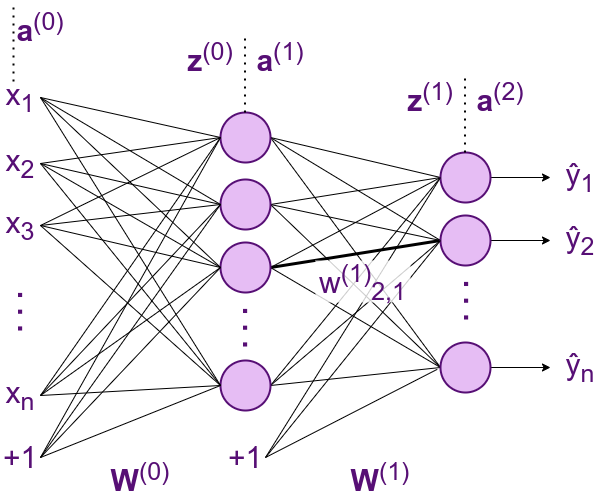

***Feedforward***:

Lembre-se que o cálculo do *forward pass* é calculado da seguinte forma:
> $a^{(l)} = f_{(l-1)}(z^{(l-1)})$

In [119]:
class Model:
    def __init__(self, layers_dims: List[int],
                 activation_funcs: List[BaseFunction],
                 initialization_method: str = "random"):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        activation_funcs: (list) a list with the activation functions
        initialization_method: (str) indicates how to initialize the parameters

        Example:

        # a model architecture with layers 2 x 1 x 2 and 2 ReLU as activation functions
        >>> m = Model([2, 1, 2], [ReLU(), ReLU()])
        """

        assert all([isinstance(d, int) for d in layers_dims]), \
        "It is expected a list of int to the param ``layers_dims"

        assert all([isinstance(a, BaseFunction) for a in activation_funcs]), \
        "It is expected a list of BaseFunction to the param ``activation_funcs´´"

        self.layers_dims = layers_dims
        self.activation_funcs = activation_funcs
        self.weights, self.bias = self.initialize_model(initialization_method)


    def __len__(self):
        return len(self.weights)


    def initialize_model(self, method="random"):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        method: (str) indicates how to initialize the parameters

        Return: a list of matrices (np.array) of weights and a list of
        matrices (np.array) of biases.
        """

        weights = []
        bias = []
        n_layers = len(self.layers_dims)
        for l in range(0, n_layers-1):
            # os pesos w_i,j conectam o i-ésimo neurônio na camada atual ao
            # j-ésimo neuronio na próxima camada
            W = np.random.randn(self.layers_dims[l], self.layers_dims[l + 1])
            b = np.random.randn(1, self.layers_dims[l + 1])

            # He et al. Normal initialization
            if method.lower() == 'he':
                W = W * np.sqrt(2/self.layers_dims[l])
                b = b * np.sqrt(2/self.layers_dims[l])

            ###################################################
            # TODO: implemente outro método de inicialização
            #
            # if method.lower() == 'Your Method':
            #   ...
            ###################################################
            elif method.lower() == 'xavier':
                W = W * np.sqrt(6/(self.layers_dims[l] + self.layers_dims[l + 1]))
                b = b * np.sqrt(6/(self.layers_dims[l] + self.layers_dims[l + 1]))

            elif method.lower() == 'zero':
                W = np.zeros(W.shape)
                b = np.zeros(b.shape)

            elif method.lower() == 'uniform':
                W = np.random.uniform(low=-1, high=1, size=W.shape)
                b = np.random.uniform(low=-1, high=1, size=b.shape)

            weights.append(W)
            bias.append(b)

        return weights, bias


    def forward(self, X):
        """
        Arguments:
        X: (np.array) input data

        Return:
        Predictions for the input data (np.array)
        """
        activation = X
        self.activations = [X]
        self.Z_list = []
        #############################################################################
        # TODO: implemente aqui o forward step.
        #
        # Algumas instruções adicionais:
        # Note que os pesos, o bias e as funções de ativação são variáveis da classe,
        # então você pode acessá-los via ``self``.
        #
        # Você deve armazenar a entrada Z de cada função de ativação em ``Z_list``,
        # e a saída das funções de ativação em ``activations``. Essas
        # informações serão importantes quando você implementar a backward pass.
        #############################################################################

        n_layers = len(self.layers_dims)
        for l in range(0, n_layers - 1):
            # Matrix product + layer biar
            Z = np.dot(activation, self.weights[l]) + self.bias[l]
            self.Z_list.append(Z)
            activation = self.activation_funcs[l](Z)
            self.activations.append(activation)

        return activation

    def predict(self, X_loader: DataLoader):
        Y_pred_after_batch = []
        for i, batch in enumerate(X_loader):
            # Ensure batch is unpacked correctly
            if isinstance(batch, list) and len(batch) >= 1:
                X = batch[0]
            else:
                X = batch

            Y_pred = self.forward(X)
            Y_pred_after_batch.extend(np.argmax(Y_pred, axis=1))

        return Y_pred_after_batch



**Verificação de integridade (*sanity check*)**

In [17]:
######## checando o Forward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), ReLU()])

X = np.array([[0, 1],
              [-1, 0]])

W1 = np.array([[2],
               [1]])
b1 = np.array([[1]])
W2 = np.array([[2, 3]])
b2 = np.array([[1, -1]])

m.weights = [W1, W2]
m.bias = [b1, b2]

expected_prediction = np.array([[5,5],
                                [1,0]])

expected_Z_list = [np.array([[2],
                             [-1]]),
                   np.array([[5,5],
                             [1,-1]]),]

expected_activations = [X,
                        np.array([[2],
                                  [0]]),
                        expected_prediction]

#forward pass
prediction = m.forward(X)

for l, (expected_z, z) in enumerate(zip(expected_Z_list, m.Z_list)):
    assert ((z - expected_z) < 1e-8).all(), \
    f"Forward pass {l}: expected Z list is {expected_z}, but it returns {z}"

for l, (expected_a, a) in enumerate(zip(expected_activations, m.activations)):
    assert (abs(a-expected_a) < 1e-8).all(), \
    f"Forward pass {l}: expected activations are {expected_a}, but it returns {a}"

assert (abs(prediction - expected_prediction) < 1e-8).all(), \
f"Forward: expected result is {expected_prediction}, but it returns {prediction}"

#### **Otimizadores**

Depois de definir a topologia/arquitetura da sua rede neural, é hora de treiná-la. Para isso, você precisa selecionar um otimizador (por exemplo, SGD, Momentum, Adagrad, Adam, RMSProp) que irá atualizar os pesos da rede.

Implemente no local indicado:

* *Stochastic Gradient Descent* (SGD);
* Outro otimizador de sua preferência. Ele deve ser uma subclasse de ``BaseOptimizer``. Para referência, leia https://www.ruder.io/optimizing-gradient-descent/.

In [150]:
class BaseOptimizer(ABC):
    def __init__(self, model):
        self.model = model

    @abstractmethod
    def step(self, grads):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.

        Return:
        """
        pass

class SGDOptimizer(BaseOptimizer):
    def __init__(self, model, lr=1e-3):
        self.model = model
        self.lr = lr

    def step(self, grads: List):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.

        Return:
        """
        ###############################################################
        # TODO: implemente o algoritmo de Stochastic Gradient Descent (SGD)
        ###############################################################

        self.model.weights = [w - self.lr * dw[0] for w, dw in zip(self.model.weights, grads)]
        self.model.bias = [b - self.lr * db[1] for b, db in zip(self.model.bias, grads)]

class AdadeltaOptimizer(BaseOptimizer):
    def __init__(self, model, rho=0.95, epsilon=1e-8):
        """
        Arguments:
        - model: the model containing the parameters (weights and biases).
        - rho: the decay factor for the moving average of squared gradients (default 0.95).
        - epsilon: a small constant to prevent division by zero (default 1e-6).
        """
        super().__init__(model)
        self.rho = rho
        self.epsilon = epsilon

        self.Eg2 = [np.zeros_like(w) for w in self.model.weights]
        self.Eg2_bias = [np.zeros_like(b) for b in self.model.bias]
        self.Edelta2 = [np.zeros_like(w) for w in self.model.weights]
        self.Edelta2_bias = [np.zeros_like(b) for b in self.model.bias]

    def step(self, grads: List):
        """
        Perform a single optimization step using Adadelta.

        Arguments:
        grads: (list) a list of tuples where each tuple contains:
            - (weights' gradient, biases' gradient) in np.array format.
        """
        for i, (dw, db) in enumerate(grads):
            self.Eg2[i] = self.rho * self.Eg2[i] + (1 - self.rho) * (dw ** 2)
            self.Eg2_bias[i] = self.rho * self.Eg2_bias[i] + (1 - self.rho) * (db ** 2)

            weight_update = - (np.sqrt(self.Edelta2[i] + self.epsilon) / np.sqrt(self.Eg2[i] + self.epsilon)) * dw
            bias_update = - (np.sqrt(self.Edelta2_bias[i] + self.epsilon) / np.sqrt(self.Eg2_bias[i] + self.epsilon)) * db

            self.model.weights[i] += weight_update
            self.model.bias[i] += bias_update

            self.Edelta2[i] = self.rho * self.Edelta2[i] + (1 - self.rho) * (weight_update ** 2)
            self.Edelta2_bias[i] = self.rho * self.Edelta2_bias[i] + (1 - self.rho) * (bias_update ** 2)

**Verificação de integridade (*sanity check*)**

A verificação de integridade do SGD é colocada após o `Trainer` porque ela utiliza o algoritmo de retropropagação (*backpropagation*) para calcular os gradientes.

#### **Treinador (Classe `Trainer`)**

Um peso $w_{i,j}$ de uma rede neural é atualizado com base no gradiente da função de perda em relação a $w_{i,j}$. Portanto, precisamos calcular o gradiente da função de perda em relação a todos os pesos e vieses em cada camada da rede. Esse processo é chamado de retropropagação (*backpropagation*), também conhecido como etapa de retrocesso.

Implemente:
* Algoritmo de retropropagação (*backpropagation*).

> *Dica: use as seguintes equações recursivas para calcular a retropropagação.*
>
> $\frac{\partial C}{\partial z^{(L-1)}} = \frac{\partial C}{\partial a^{(L)}} \cdot \frac{\partial C}{\partial z^{(L-1)}}$
>
> $\frac{\partial C}{\partial z^{(l)}} = [\frac{\partial C}{\partial z^{(l+1)}} \cdot W_{(l+1)}^T] \odot \frac{\partial f_{(l)}}{\partial z^{(l)}}$
>
> $\frac{\partial C}{\partial W^{(l)}} = \frac{1}{m} \cdot a^{(l)^T} \cdot \frac{\partial C}{\partial z^{(l)}}$
>
> $\frac{\partial C}{\partial b^{(l)}} = \frac{1}{m} \sum_{i=1}^{m} \frac{\partial C}{\partial z_i^{(l)}}$
>
>onde $C$ é sua função de custo/perda, $m$ é o tamanho do lote, $a^{(L)}$ é a saída da última função de ativação, $z_i^{(l)}$ é a i-ésima linha da matriz $z^{(l)}$, e $\odot$ é o [produto de Hadamard](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) / produto elemento a elemento.

In [32]:
class Trainer:
    def __init__(self, model, optimizer, loss_func):
        self.model = model
        self.optimizer = optimizer
        self.loss_func: BaseFunction = loss_func
        self.batch_size = 0

    def backward(self, Y):
        """
        Arguments:
        Y: (np.array) ground truth/label vector.

        Return:
        A list of tuples of matrices (weights' gradient, biases' gradient) both in np.array format.
        The order of this list should be the same as the model's weights.
        For example: [(dW0, db0), (dW1, db1), ... ].
        """
        ############################################################
        # TODO: implemente aqui o backward step.
        ############################################################
        activations = self.model.activations
        z_list = self.model.Z_list
        n_layers = len(self.model.layers_dims)
        grads = []

        # Tamanho do batch
        m = Y.shape[0]

        for l in range(n_layers - 2, -1, -1):
            d = self.loss_func.grad(activations[-1], Y) if l == n_layers - 2 else np.dot(delta, self.model.weights[l+1].T)
            delta = d * self.model.activation_funcs[l].grad(z_list[l])
            dW = - np.dot(activations[l].T, delta) / m
            db = - np.sum(delta, axis=0, keepdims=True) / m

            grads.insert(0, (dW, db))

        return grads



    def train(self, n_epochs: int, train_loader: DataLoader, val_loader: DataLoader):
        """
        Arguments:
        n_epochs: (int) number of epochs
        train_loader: (DataLoader) train DataLoader
        val_loader: (DataLoader) validation DataLoader

        Return:
        A dictionary with the log of train and validation loss along the epochs
        """
        log_dict = {'epoch': [],
                   'train_loss': [],
                   'val_loss': []}

        bal_dict = {
            'epoch': [],
            'train_auc': [],
            'val_auc': []
        }

        self.batch_size = train_loader.batch_size
        for epoch in tqdm.tqdm_notebook(range(n_epochs)):
            Y_after_batch = []
            Y_pred_after_batch = []

            train_loss_history = []
            for i, batch in enumerate(train_loader):
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()
                Y_pred = self.model.forward(X)

                # Grava loss
                train_loss = self.loss_func(Y, Y_pred)
                train_loss_history.append(train_loss)

                # Grava classes preditas e verdadeiras
                Y_after_batch.extend(np.argmax(Y, axis=1))
                Y_pred_after_batch.extend(np.argmax(Y_pred, axis=1))

                grads = self.backward(Y)
                self.optimizer.step(grads)

            Y_after_batch_val = []
            Y_pred_after_batch_val = []

            val_loss_history = []
            for i, batch in enumerate(val_loader):
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()
                Y_pred = self.model.forward(X)

                # Grava loss
                val_loss = self.loss_func(Y, Y_pred)
                val_loss_history.append(val_loss)

                # Grava classes preditas e verdadeiras
                Y_after_batch_val.extend(np.argmax(Y, axis=1))
                Y_pred_after_batch_val.extend(np.argmax(Y_pred, axis=1))

            # anexando a perda ao historico
            train_loss = np.array(train_loss_history).mean()
            val_loss = np.array(val_loss_history).mean()

            log_dict['epoch'].append(epoch)
            log_dict['train_loss'].append(train_loss)
            log_dict['val_loss'].append(val_loss)

            # Computa accuracia balanceada
            train_auc = balanced_accuracy_score(Y_after_batch, Y_pred_after_batch)
            val_auc = balanced_accuracy_score(Y_after_batch_val, Y_pred_after_batch_val)

            bal_dict['epoch'].append(epoch)
            bal_dict['train_auc'].append(train_auc)
            bal_dict['val_auc'].append(val_auc)

        return log_dict, bal_dict

**Verificação de integridade (*sanity check*)**

In [20]:
######## checando o Backward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1],
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)

# Deixamos esse valor caso você precise checar seus resultados
#
# expected_dZ1 = np.array([[ 0.5       , -0.5       ],
#                         [-0.11920292,  0.11920292]])
#
# expected_dZ0 = np.array([[-0.5],
#                          [ 0. ]])
#
# y_pred = np.array([[0.5       , 0.5       ],
#                    [0.88079708, 0.11920292]])


expected_dW1 = np.array([[ 0.5, -0.5]])

expected_db1 = np.array([[ 0.19039854, -0.19039854]])

expected_dW0 = np.array([[ 0.  ],
                         [-0.25]])

expected_db0 = np.array([[-0.25]])

dW1, db1 = grads[1]
assert (abs(expected_dW1 - dW1) < 1e-8).all(), f"Expected result for dW1 is {expected_dW1}, but it returns {dW1}"
assert (abs(expected_db1 - db1) < 1e-8).all(), f"Expected result for db1 is {expected_db1}, but it returns {db1}"

dW0, db0 = grads[0]
assert (abs(expected_dW0 - dW0) < 1e-8).all(), f"Expected result for dW0 is {expected_dW0}, but it returns {dW0}"
assert (abs(expected_db0 - db0) < 1e-8).all(), f"Expected result for db0 is {expected_db0}, but it returns {db0}"

In [21]:
grads

[(array([[-0.  ],
         [-0.25]]),
  array([[-0.25]])),
 (array([[ 0.5, -0.5]]), array([[ 0.19039854, -0.19039854]]))]

In [22]:
######## checando o SGD Optimizer ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1],
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)
opt = SGDOptimizer(m, lr=1)
opt.step(grads)

expected_W0 = np.array([[2.  ],
                        [1.25]])
expected_b0 = np.array([[1.25]])

expected_W1 = np.array([[1.5, 3.5]])
expected_b1 = np.array([[ 0.80960146, -0.80960146]])

W0, b0 = m.weights[0], m.bias[0]
assert (abs(expected_W0 - W0) < 1e-8).all(), f"Expected result for W0 after SGD update step is {expected_W0}, but it returns {W0}"
assert (abs(expected_b0 - b0) < 1e-8).all(), f"Expected result for b0 after SGD update step is {expected_b0}, but it returns {b0}"

W1, b1 = m.weights[1], m.bias[1]
assert (abs(expected_W1 - W1) < 1e-8).all(), f"Expected result for W1 after SGD update step is {expected_W1}, but it returns {W1}"
assert (abs(expected_b1 - b1) < 1e-8).all(), f"Expected result for b1 after SGD update step is {expected_b1}, but it returns {b1}"

#### **Exemplo de uso**

Exemplo de uso do *framework* que acabamos de criar.

In [39]:
def plot_loss_and_auc(history_loss, history_auc):
    """
    Plot both loss and AUC history along epochs
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot loss history
    ax1.plot(history_loss['train_loss'], color='#407cdb', label='Train Loss')
    ax1.plot(history_loss['val_loss'], color='#db5740', label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss along the training')
    ax1.legend(loc='upper right')

    # Plot balanced accuracy history
    ax2.plot(history_auc['train_auc'], color='#407cdb', label='Train AUC')
    ax2.plot(history_auc['val_auc'], color='#db5740', label='Validation AUC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('balanced accuracy')
    ax2.set_title('balanced accuracy along the training')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix_percent(Y_true, Y_pred):
    cm = confusion_matrix(Y_true, Y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=np.unique(Y_true),
           yticklabels=np.unique(Y_true),
           title='Confusion Matrix (%)',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f'
    thresh = cm_percent.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm_percent[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_percent[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


In [ ]:
model = Model([784, 392, 100, 11], [ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
loss_history, auc_history = trainer.train(200, train_loader, val_loader)

<ipython-input-76-4cb6f4923b08>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

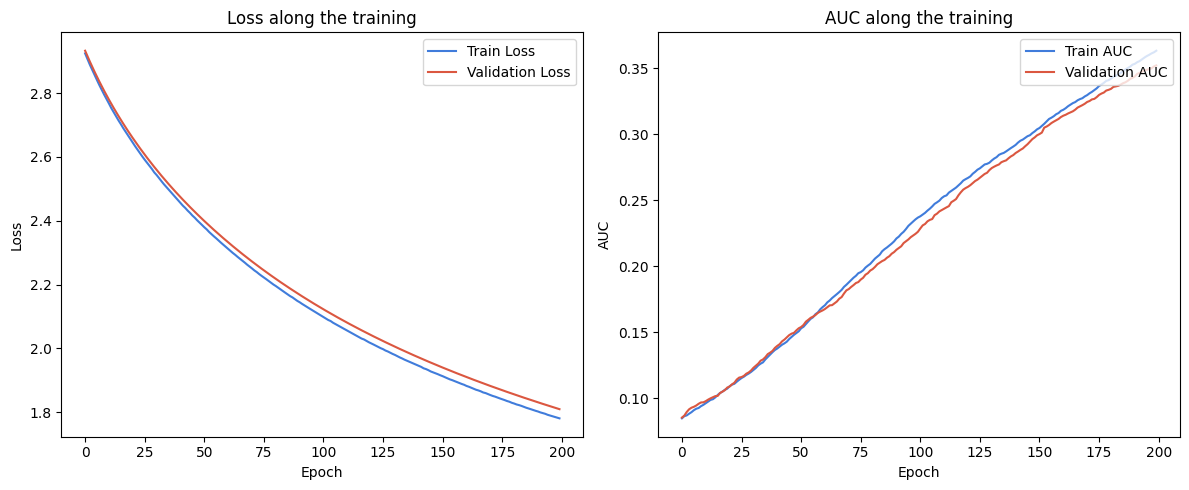

In [ ]:
plot_loss_and_auc(loss_history, auc_history)

## 3. Atividades Exploratórias

Para todos os exercícios, plote a perda ao longo das épocas e reporte o desempenho do seu modelo no conjunto de validação. Cuidado com *underfitting* e *overfitting*.

1. (1 ponto) Projete uma Rede Neural, usando uma ou duas camadas ocultas, ReLU e softmax como funções de ativação, inicialização de pesos aleatória e SGD para treiná-la. Você deve escolher uma taxa de aprendizado apropriada e um número de épocas.

<ipython-input-32-d235b8fd54cd>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

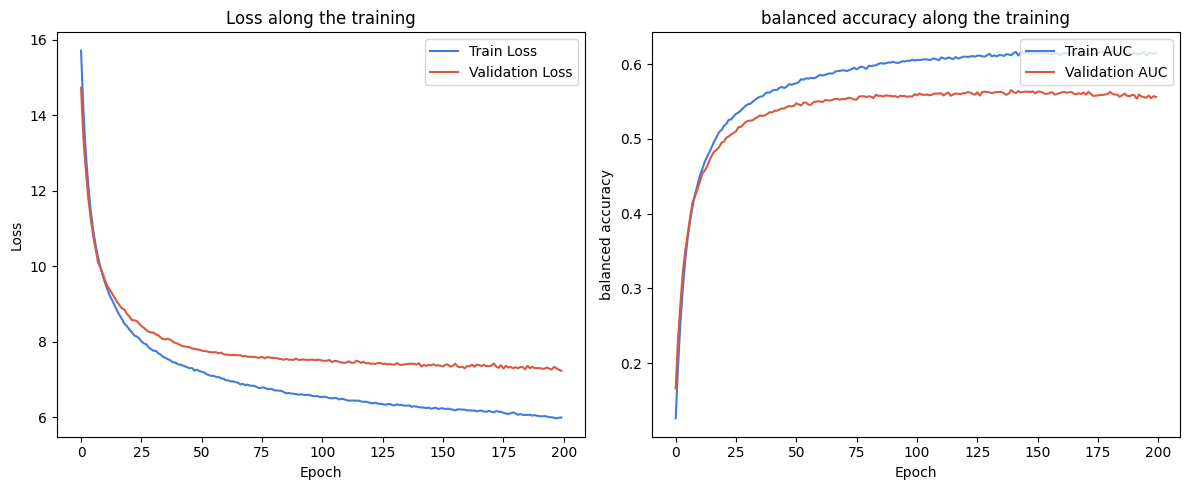

In [42]:
model = Model([784, 392, 100, 11], [ReLU(), ReLU(), Softmax()])
opt = SGDOptimizer(model, lr=5e-5)
trainer = Trainer(model, opt, CrossEntropy())
loss_history, auc_history = trainer.train(200, train_loader, val_loader)
plot_loss_and_auc(loss_history, auc_history)

In [46]:
Y = y_val
Y_pred = model.predict(val_loader)
print(classification_report(Y, Y_pred))

              precision    recall  f1-score   support

           0       0.42      0.45      0.43       487
           1       0.36      0.35      0.36       260
           2       0.37      0.41      0.39       250
           3       0.75      0.76      0.75       275
           4       0.42      0.39      0.41       438
           5       0.49      0.41      0.44       464
           6       0.71      0.75      0.73      1181
           7       0.83      0.89      0.86       427
           8       0.87      0.87      0.87       435
           9       0.34      0.35      0.34       473
          10       0.55      0.50      0.52       616

    accuracy                           0.58      5306
   macro avg       0.55      0.56      0.55      5306
weighted avg       0.58      0.58      0.58      5306



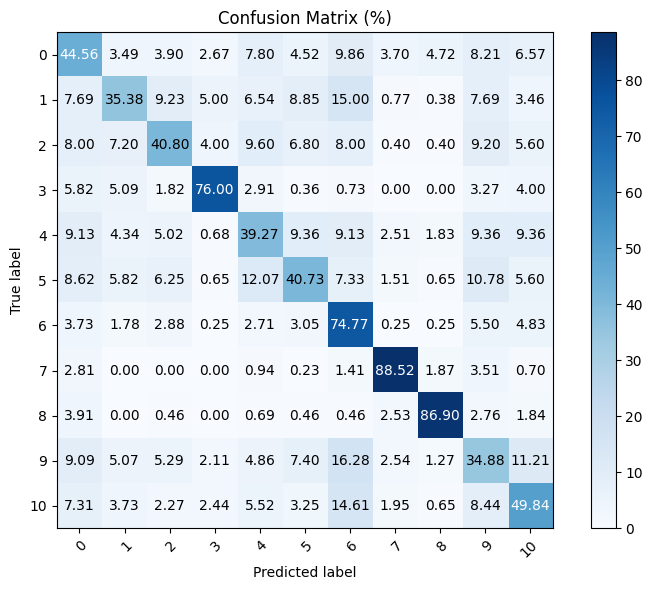

In [47]:
Y = y_val
Y_pred = model.predict(val_loader)
plot_confusion_matrix_percent(Y, Y_pred)

> **Quais foram suas conclusões? (1-2 parágrafos)**
>
> **Resposta**
>> Ao analisarmos o gráfico de loss por época, percebemos que o modelo está aprendendo de forma adequada, ou seja, sem apresentar sinais claros de overfitting ou underfitting. A redução contínua da perda (loss) indica que o modelo está ajustando seus parâmetros de maneira eficiente durante o treinamento. No entanto, pode-se argumentar que, por volta da 100ª época, o modelo começa a apresentar uma performance menos consistente. Isso é evidenciado pela acurácia balanceada, que atinge um platô na validação e não consegue superar o valor de 0,6. Esse comportamento sugere que, após esse ponto, o modelo pode ter atingido um limite na sua capacidade de generalização, possivelmente devido a uma saturação do aprendizado ou a um fator como a complexidade do modelo.

>> Quando observamos a matriz de confusão, nota-se que o modelo consegue classificar muito bem as classes 3, 7 e 8, confundindo-as pouco com outras classes. O desempenho é semelhante para a classe 6, embora haja uma maior confusão dessa classe com as classes 9 e 10. Nas outras classes, o modelo tem um desempenho inferior, classificando menos de 50% dos dados corretamente. Embora possamos atribuir esses resultados ao fato de as classes com maior número de amostras serem melhor classificadas, é importante destacar que a classe 3 possui menos dados do que a classe 4, e ainda assim o modelo tem um desempenho superior na classificação da classe 3.

>> Os resultados descritos pela matriz de confusão são suportados pelo reporte de classificação no qual podemos observar que as classes 3, 6, 7 e 8 possuem melhores metricas de recall e precisão enquanto que as classes 0, 1, 2, 4, 5 e 9 são muito a quem dester resultados.

2. (2 pontos) Experimente outras duas técnicas de inicialização de pesos e *bias* (normalização de He et al. e a outra que você implementou).

In [55]:
def train_model_based_on_initialization(initialization_method):
  model = Model([784, 392, 100, 11], [ReLU(), ReLU(), Softmax()], initialization_method=initialization_method)
  opt = SGDOptimizer(model, lr=5e-5)
  trainer = Trainer(model, opt, CrossEntropy())
  loss_history, auc_history = trainer.train(200, train_loader, val_loader)
  plot_loss_and_auc(loss_history, auc_history)

  print(f'Method: {initialization_method}, loss {min(loss_history["val_loss"])}')

  Y = y_val
  Y_pred = model.predict(val_loader)

  print(classification_report(Y, Y_pred))
  plot_confusion_matrix_percent(Y, Y_pred)


<ipython-input-32-d235b8fd54cd>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

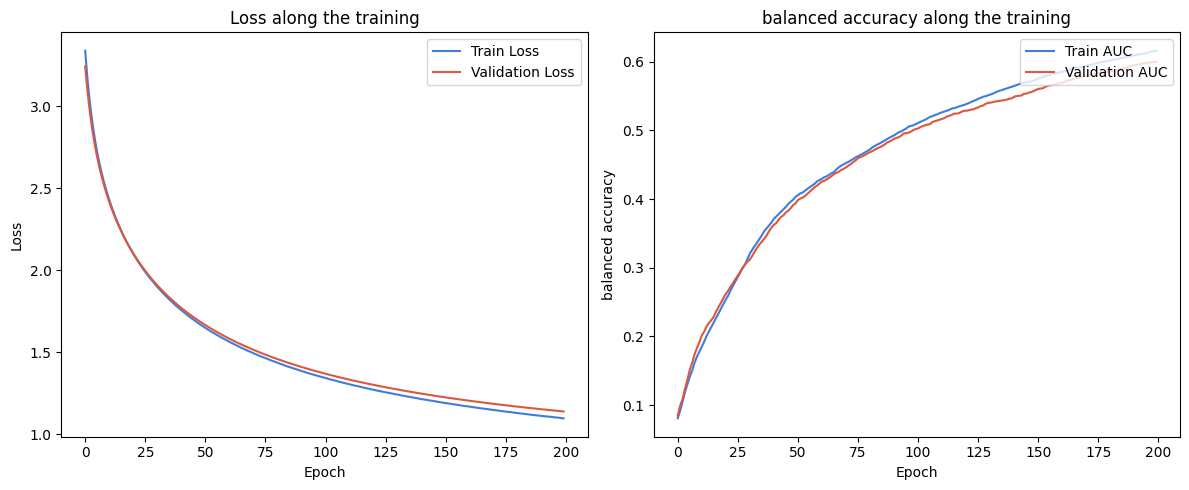

Method: he, loss 1.1382226680290197
              precision    recall  f1-score   support

           0       0.47      0.45      0.46       487
           1       0.56      0.33      0.42       260
           2       0.60      0.46      0.52       250
           3       0.72      0.77      0.74       275
           4       0.50      0.42      0.46       438
           5       0.53      0.56      0.54       464
           6       0.74      0.88      0.80      1181
           7       0.82      0.87      0.85       427
           8       0.84      0.91      0.88       435
           9       0.45      0.38      0.42       473
          10       0.56      0.56      0.56       616

    accuracy                           0.64      5306
   macro avg       0.62      0.60      0.60      5306
weighted avg       0.63      0.64      0.63      5306



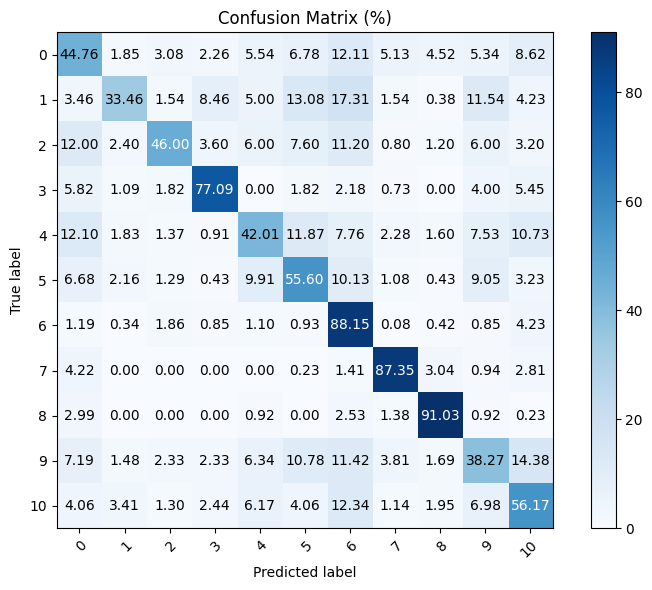

In [56]:
train_model_based_on_initialization("he")

<ipython-input-32-d235b8fd54cd>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

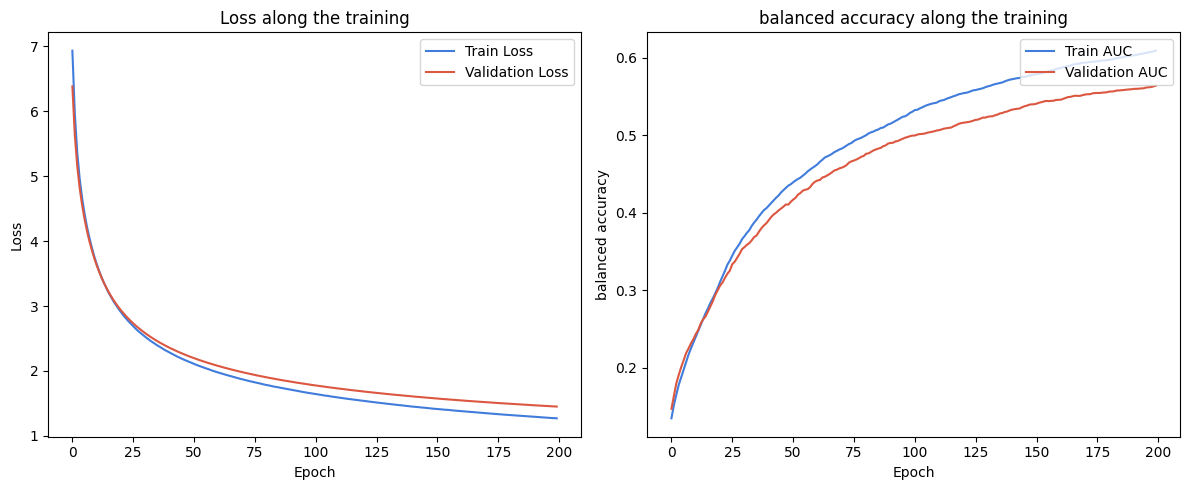

Method: xavier, loss 1.451207049687113
              precision    recall  f1-score   support

           0       0.41      0.43      0.42       487
           1       0.49      0.45      0.47       260
           2       0.45      0.42      0.43       250
           3       0.68      0.65      0.67       275
           4       0.43      0.38      0.41       438
           5       0.46      0.44      0.45       464
           6       0.76      0.82      0.79      1181
           7       0.84      0.84      0.84       427
           8       0.86      0.88      0.87       435
           9       0.37      0.34      0.36       473
          10       0.53      0.55      0.54       616

    accuracy                           0.60      5306
   macro avg       0.57      0.56      0.57      5306
weighted avg       0.59      0.60      0.60      5306



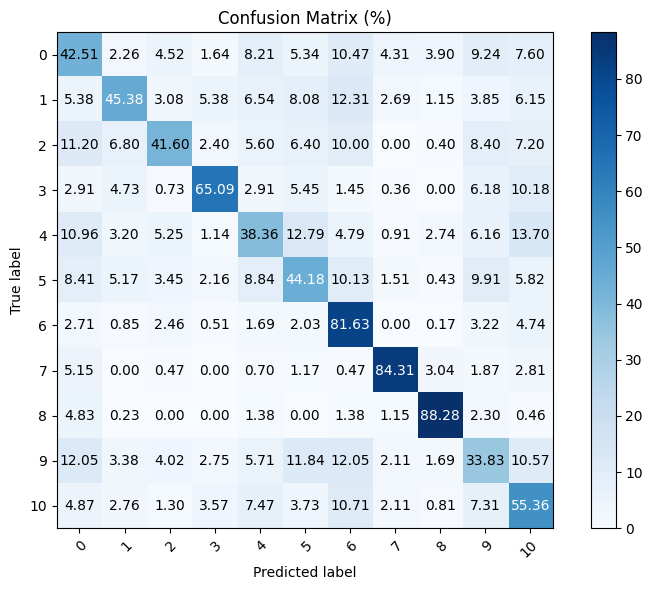

In [57]:
train_model_based_on_initialization("xavier")

<ipython-input-32-d235b8fd54cd>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

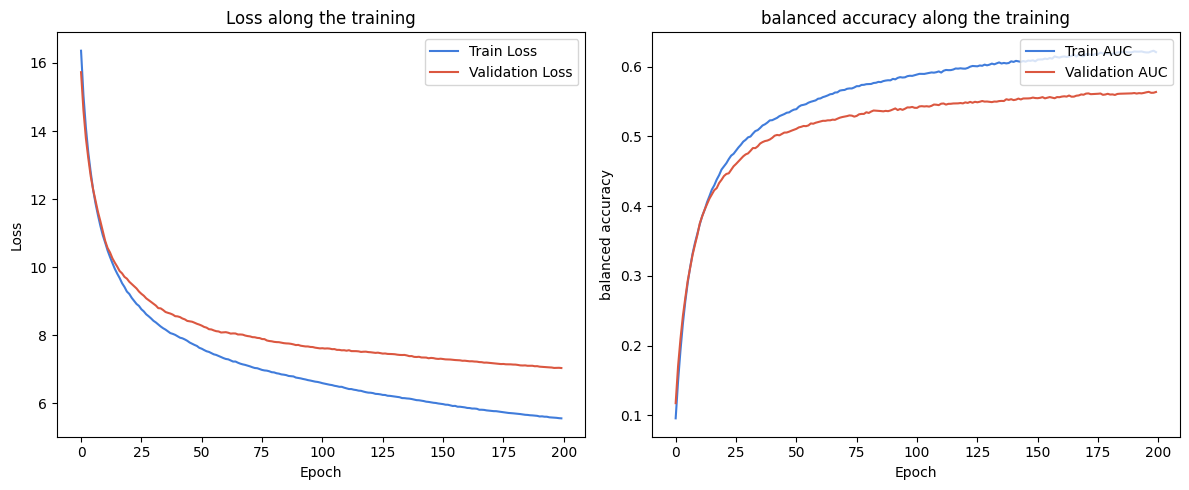

Method: uniform, loss 7.0369742372496145
              precision    recall  f1-score   support

           0       0.40      0.39      0.40       487
           1       0.43      0.43      0.43       260
           2       0.44      0.52      0.48       250
           3       0.67      0.73      0.70       275
           4       0.43      0.41      0.42       438
           5       0.45      0.45      0.45       464
           6       0.75      0.76      0.75      1181
           7       0.82      0.83      0.83       427
           8       0.88      0.85      0.87       435
           9       0.34      0.34      0.34       473
          10       0.51      0.49      0.50       616

    accuracy                           0.58      5306
   macro avg       0.56      0.56      0.56      5306
weighted avg       0.58      0.58      0.58      5306



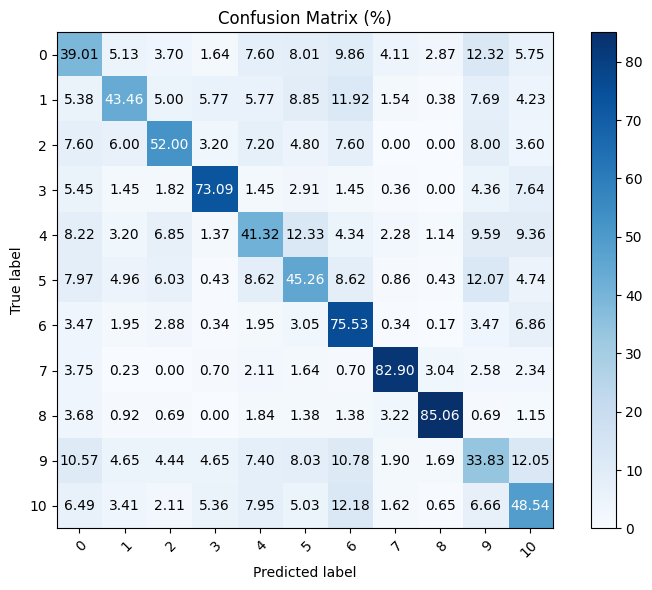

In [58]:
train_model_based_on_initialization("uniform")

<ipython-input-32-d235b8fd54cd>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

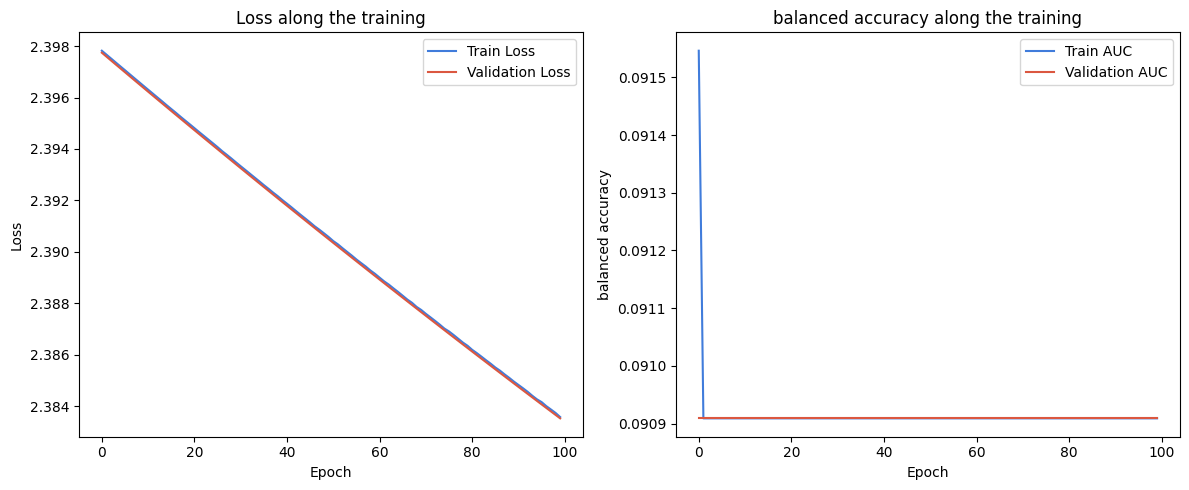

Method: zero, loss 2.383521753229175


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       487
           1       0.00      0.00      0.00       260
           2       0.00      0.00      0.00       250
           3       0.00      0.00      0.00       275
           4       0.00      0.00      0.00       438
           5       0.00      0.00      0.00       464
           6       0.22      1.00      0.36      1181
           7       0.00      0.00      0.00       427
           8       0.00      0.00      0.00       435
           9       0.00      0.00      0.00       473
          10       0.00      0.00      0.00       616

    accuracy                           0.22      5306
   macro avg       0.02      0.09      0.03      5306
weighted avg       0.05      0.22      0.08      5306



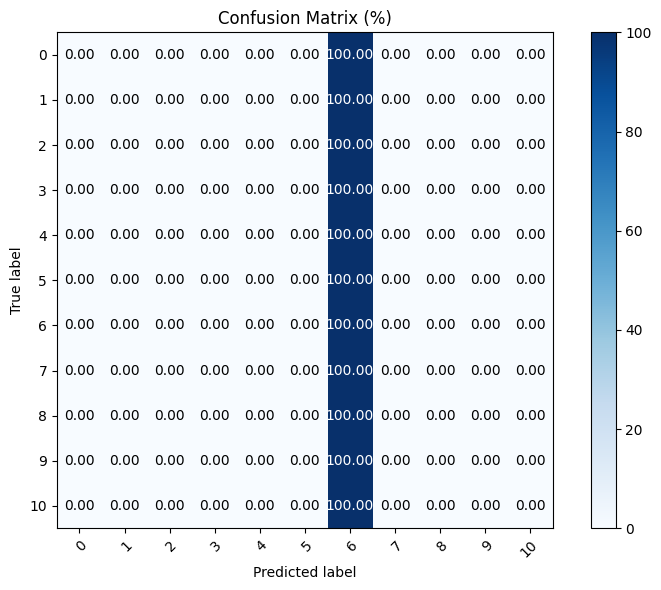

In [51]:
train_model_based_on_initialization("zero")

> **Quais são as conclusões? Como as técnicas influenciam o desempenho dos modelos? (1-2 parágrafos)**
>

> **Resposta**
>>Ao analisar os gráficos e as métricas apresentadas, observa-se que as inicializações de He e Xavier resultam em uma perda (loss) significativamente menor em comparação com outras abordagens, como as distribuições uniforme e normal. O método de He, em particular, obteve a melhor loss e a maior acurácia balanceada. Isso indica que a inicialização de He pode otimizar de forma mais eficaz a propagação dos gradientes, além de classificar as classes de maneira mais precisa em comparação com o método de Xavier. Esse desempenho superior do método de He pode ser atribuído ao fato de ele ter sido projetado especificamente para lidar com a função de ativação ReLU, utilizada neste experimento.

>>Outro ponto notável é que o modelo com inicialização dos pesos e bias em zero não aprendeu nada, classificando todas as amostras como pertencentes à classe 6. Esse comportamento pode ser explicado pelo fato de que, ao inicializar os pesos e bias com zero, as atualizações dos gradientes durante o treinamento se tornam simétricas, o que impede a rede de aprender características diferenciadas das entradas. Como resultado, todos os neurônios das camadas ocultas produzem a mesma saída, fazendo com que o modelo atribua a mesma classe a todas as amostras, sem ser capaz de capturar as nuances dos dados.

3. (1 ponto) Escolha a técnica de inicialização de pesos e *bias* que resultou no melhor desempenho e experimente a outra função de ativação que você implementou.

In [59]:
def train_with_different_activation_function(activation_function):
  model = Model([784, 392, 100, 11], [activation_function, activation_function, Softmax()], initialization_method="he")
  opt = SGDOptimizer(model, lr=5e-5)
  trainer = Trainer(model, opt, CrossEntropy())
  loss_history, auc_history = trainer.train(200, train_loader, val_loader)
  plot_loss_and_auc(loss_history, auc_history)

  print(f'Method: {activation_function}, loss {min(loss_history["val_loss"])}')

  Y = y_val
  Y_pred = model.predict(val_loader)

  print(classification_report(Y, Y_pred))
  plot_confusion_matrix_percent(Y, Y_pred)

<ipython-input-32-d235b8fd54cd>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

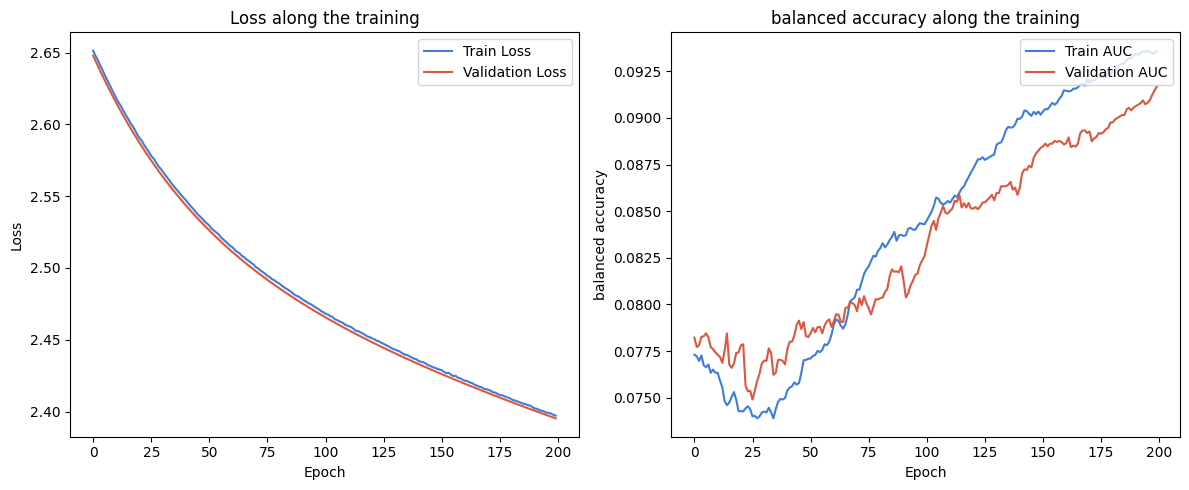

Method: <__main__.Binary object at 0x7dd9e7b007f0>, loss 2.395306871352784
              precision    recall  f1-score   support

           0       0.17      0.11      0.14       487
           1       0.00      0.00      0.00       260
           2       0.06      0.03      0.04       250
           3       0.03      0.00      0.01       275
           4       0.07      0.04      0.05       438
           5       0.03      0.01      0.02       464
           6       0.21      0.62      0.32      1181
           7       0.06      0.02      0.03       427
           8       0.19      0.03      0.05       435
           9       0.07      0.03      0.04       473
          10       0.14      0.11      0.12       616

    accuracy                           0.17      5306
   macro avg       0.09      0.09      0.07      5306
weighted avg       0.12      0.17      0.12      5306



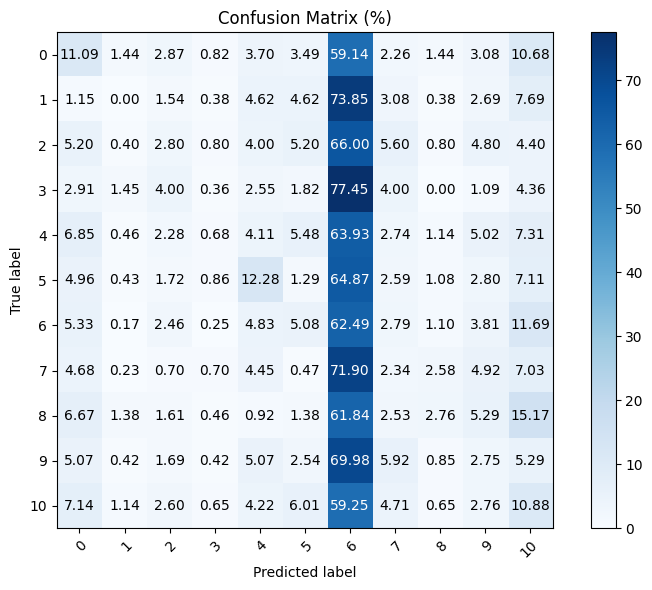

In [60]:
train_with_different_activation_function(Binary())

<ipython-input-32-d235b8fd54cd>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

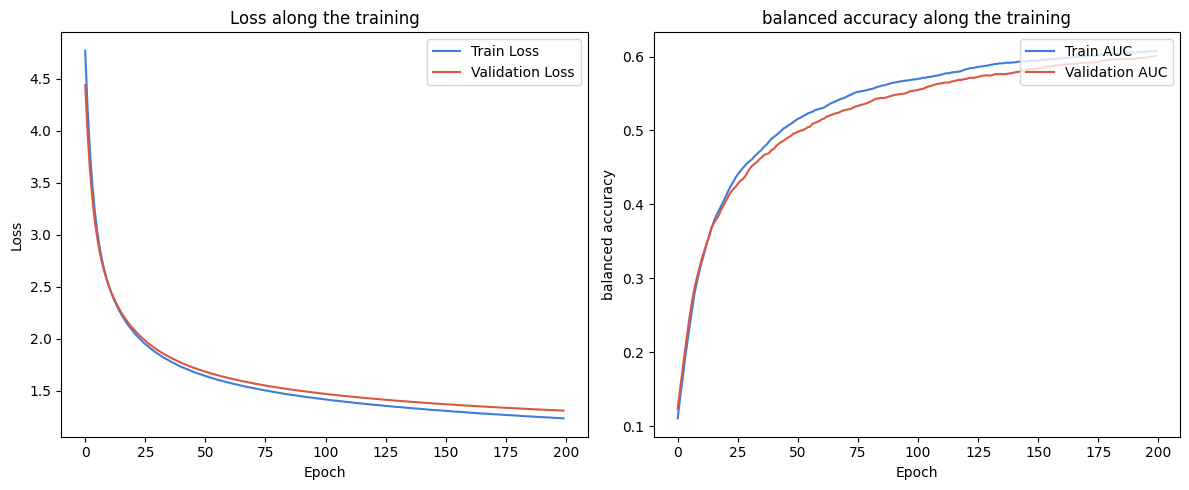

Method: <__main__.Identity object at 0x7dd9e6a6ee60>, loss 1.3063880614249546
              precision    recall  f1-score   support

           0       0.57      0.39      0.47       487
           1       0.46      0.42      0.43       260
           2       0.50      0.49      0.49       250
           3       0.56      0.74      0.64       275
           4       0.54      0.41      0.47       438
           5       0.54      0.57      0.55       464
           6       0.77      0.86      0.82      1181
           7       0.74      0.89      0.81       427
           8       0.76      0.92      0.83       435
           9       0.45      0.33      0.38       473
          10       0.60      0.59      0.59       616

    accuracy                           0.64      5306
   macro avg       0.59      0.60      0.59      5306
weighted avg       0.62      0.64      0.63      5306



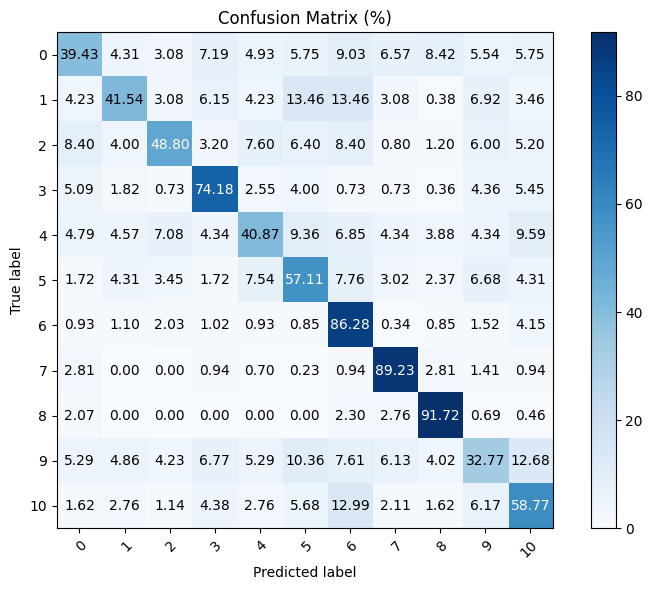

In [61]:
train_with_different_activation_function(Identity())

> **Quais são as conclusões? Isso faz alguma diferença nos resultados? (1-2 parágrafos)**
>
> **Resposta**
>>Para esta questão, analisamos outras duas funções de ativação: a binária e a identidade. Como resultados notáveis, observamos que a função binária apresenta um desempenho muito ruim, classificando quase todo o dataset como pertencente à classe 6. Por outro lado, a função de ativação identidade apresenta um desempenho relativamente bom, aproximando-se dos resultados obtidos com a função ReLU.

>>Acreditamos que os resultados obtidos com o uso da função binária se devem ao fato de ela zerar boa parte dos pesos durante o feedforward, o que resulta em um problema semelhante ao da inicialização dos pesos em zero. Nesse cenário, o modelo acaba constantemente "zerando" a informação que poderia ser útil para seu aprendizado. Por outro lado, o desempenho relativamente bom da função identidade pode ser atribuído ao fato de que ela permite a propagação dos valores sem alteração significativa, o que facilita o fluxo de informações durante o treinamento. Contudo, apesar de sua eficácia relativa, a função identidade não é tão otimizada quanto a ReLU, que é mais eficaz na adaptação e no aprendizado de redes profundas, especialmente ao lidar com problemas de gradientes em camadas sucessivas.

4. (3 pontos) Explore diferentes arquiteturas de rede, variando o número de camadas e o número de neurônios em cada camada. É um experimento empírico.

In [68]:
def train_with_different_layers(neurons_per_layer, activation_func_per_layer):
  model = Model(neurons_per_layer, activation_func_per_layer, initialization_method='he')
  opt = SGDOptimizer(model, lr=5e-5)
  trainer = Trainer(model, opt, CrossEntropy())
  loss_history, auc_history = trainer.train(200, train_loader, val_loader)
  plot_loss_and_auc(loss_history, auc_history)

  Y = y_val
  Y_pred = model.predict(val_loader)

  print(classification_report(Y, Y_pred))
  plot_confusion_matrix_percent(Y, Y_pred)

<ipython-input-32-d235b8fd54cd>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

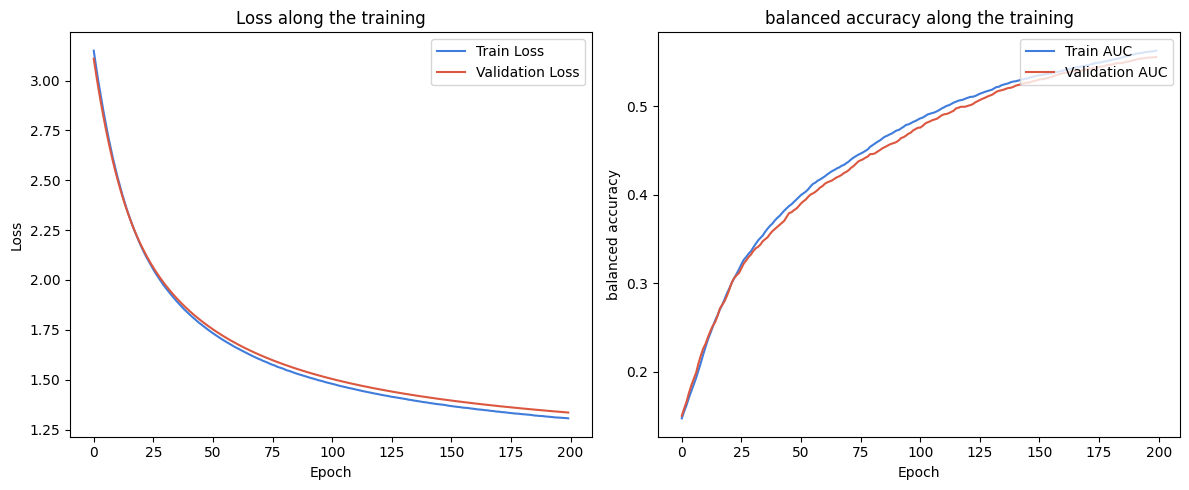

              precision    recall  f1-score   support

           0       0.57      0.29      0.38       487
           1       0.39      0.34      0.36       260
           2       0.45      0.47      0.46       250
           3       0.47      0.73      0.57       275
           4       0.49      0.34      0.40       438
           5       0.51      0.53      0.52       464
           6       0.74      0.85      0.79      1181
           7       0.63      0.87      0.73       427
           8       0.70      0.92      0.80       435
           9       0.44      0.26      0.32       473
          10       0.55      0.51      0.53       616

    accuracy                           0.60      5306
   macro avg       0.54      0.56      0.53      5306
weighted avg       0.58      0.60      0.57      5306



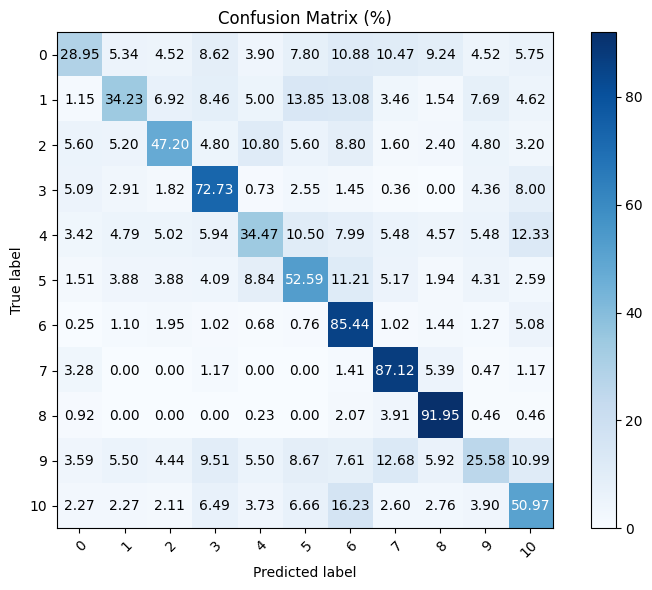

In [165]:
train_with_different_layers([784, 11], [Softmax()])

<ipython-input-32-d235b8fd54cd>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

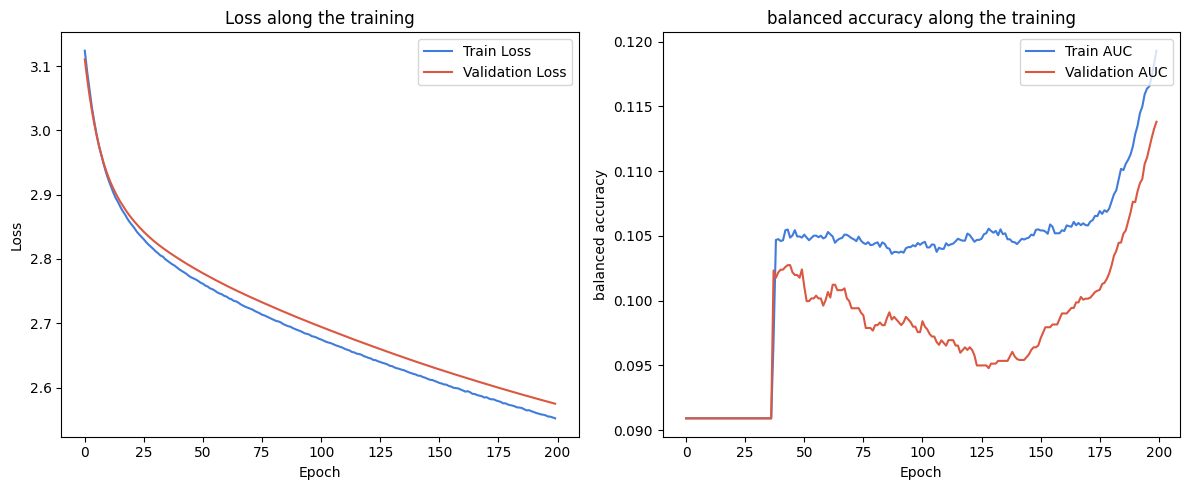

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       487
           1       0.06      0.72      0.12       260
           2       0.00      0.00      0.00       250
           3       0.00      0.00      0.00       275
           4       0.07      0.33      0.12       438
           5       0.00      0.00      0.00       464
           6       0.94      0.15      0.27      1181
           7       0.12      0.04      0.07       427
           8       0.00      0.00      0.00       435
           9       0.00      0.00      0.00       473
          10       0.00      0.00      0.00       616

    accuracy                           0.10      5306
   macro avg       0.11      0.11      0.05      5306
weighted avg       0.23      0.10      0.08      5306



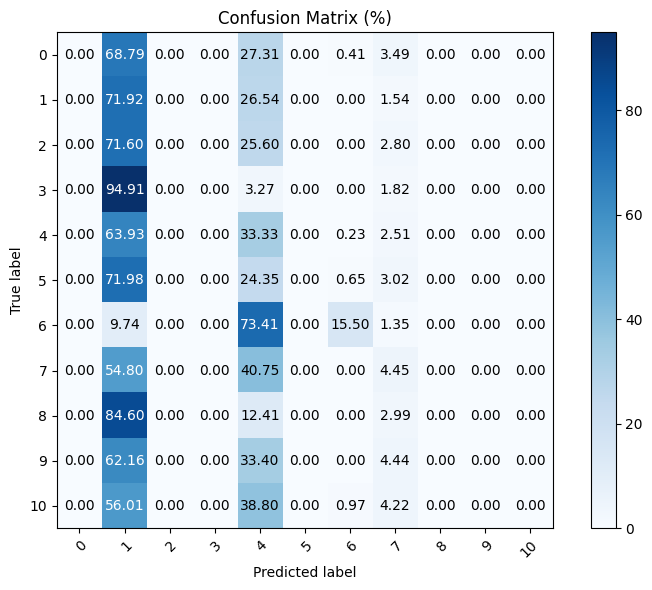

In [169]:
train_with_different_layers([784, 1, 11], [ReLU(), Softmax()])

<ipython-input-32-d235b8fd54cd>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

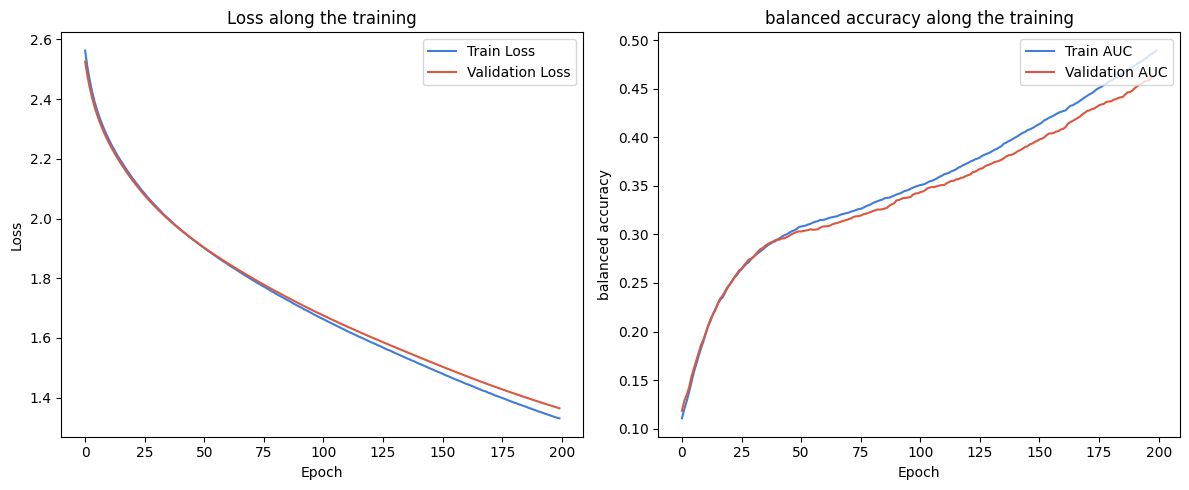

              precision    recall  f1-score   support

           0       0.48      0.23      0.31       487
           1       0.47      0.16      0.24       260
           2       0.58      0.32      0.41       250
           3       0.62      0.14      0.23       275
           4       0.39      0.39      0.39       438
           5       0.45      0.42      0.43       464
           6       0.59      0.91      0.71      1181
           7       0.73      0.90      0.81       427
           8       0.88      0.92      0.90       435
           9       0.34      0.28      0.31       473
          10       0.38      0.44      0.41       616

    accuracy                           0.55      5306
   macro avg       0.54      0.46      0.47      5306
weighted avg       0.53      0.55      0.51      5306



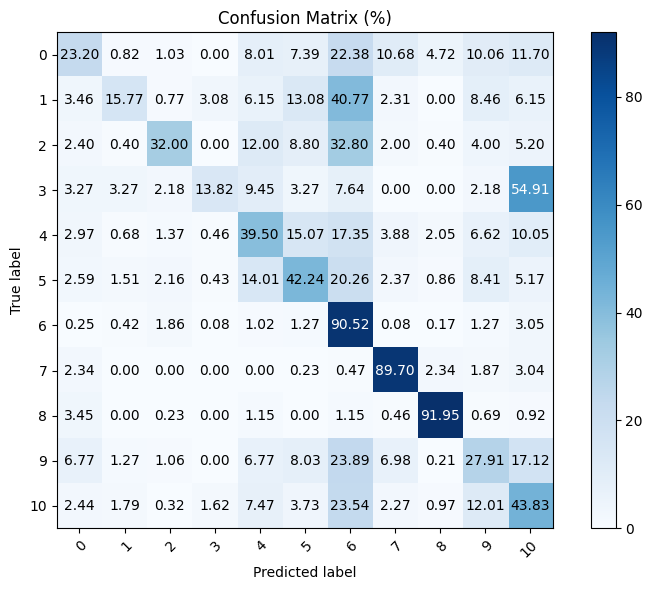

In [69]:
train_with_different_layers([784, 392, 196, 98, 49, 25, 11], [ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), Softmax()])

<ipython-input-32-d235b8fd54cd>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

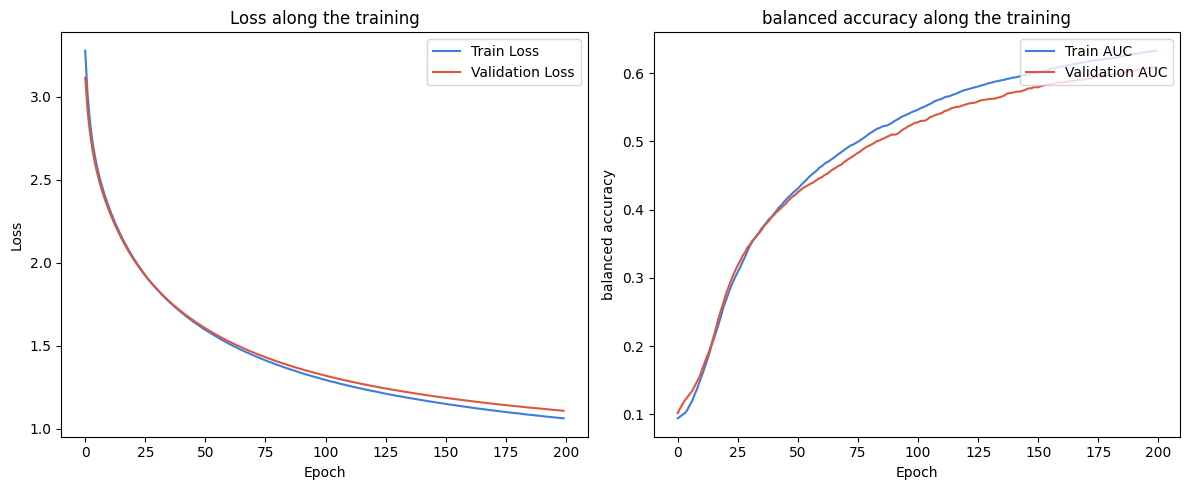

              precision    recall  f1-score   support

           0       0.48      0.44      0.46       487
           1       0.60      0.39      0.47       260
           2       0.58      0.47      0.52       250
           3       0.77      0.78      0.77       275
           4       0.48      0.45      0.47       438
           5       0.49      0.51      0.50       464
           6       0.75      0.88      0.81      1181
           7       0.84      0.89      0.86       427
           8       0.89      0.90      0.90       435
           9       0.46      0.42      0.44       473
          10       0.59      0.58      0.59       616

    accuracy                           0.65      5306
   macro avg       0.63      0.61      0.62      5306
weighted avg       0.64      0.65      0.64      5306



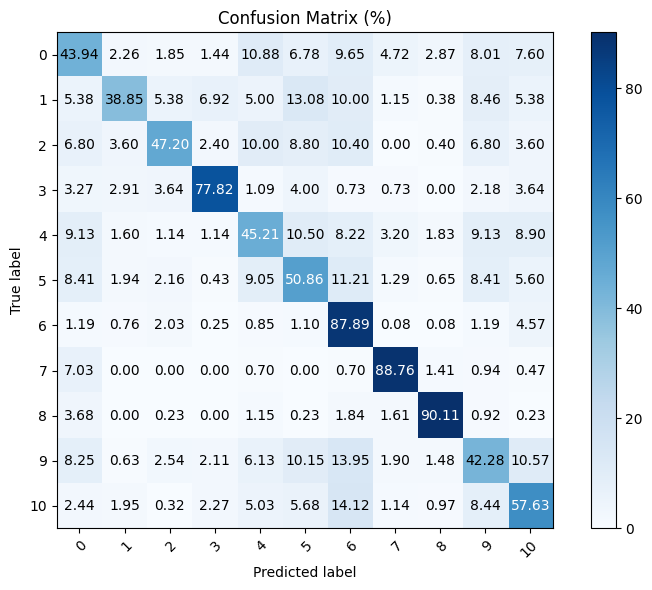

In [70]:
train_with_different_layers([784, 392, 196, 98, 11], [ReLU(), ReLU(), ReLU(), Softmax()])

> **Quais são as conclusões? Como o número de camadas impacta o desempenho dos modelos? (2-4 parágrafos)**
>
> **Reposta**
>> Para esta questão, foram testados quatro modelos com diferentes arquiteturas: *softmax_only*, *one_neuron*, *too_deep* e *medium_deep*, cujas estruturas são, respectivamente, [784, 11], [784, 1, 11], [784, 392, 196, 98, 49, 25, 11] e [784, 392, 196, 98, 11]. É importante destacar que nenhuma dessas arquiteturas obteve um desempenho significativamente superior à arquitetura fornecida como exemplo, [784, 392, 100, 11]. Todos esses modelos alcançaram uma acurácia balanceada entre 0,50 e 0,60, resultados similares aos da arquitetura de exemplo, exceto pelo modelo *one_neuron*, cuja acurácia balanceada ficou em torno de 0,12.

>> O resultado mais interessante foi obtido pelo modelo *softmax_only*, que, apesar de ter um número significativamente menor de parâmetros, apresentou um desempenho semelhante ao da arquitetura de exemplo. Isso sugere que uma rede mais profunda pode não ser essencial para a tarefa de classificação de imagens médicas. Essa conclusão é reforçada pelo modelo *too_deep*, que, mesmo com várias camadas adicionais, não apresentou melhorias significativas em relação às demais redes ao ser treinado pelo mesmo número de épocas (200).

>> A análise desses modelos revela que a profundidade da rede nem sempre corresponde a uma melhoria na precisão para essa tarefa específica. No caso do modelo medium_deep, a presença de algumas camadas intermediárias ajudou a capturar características relevantes, sem introduzir o alto número de parâmetros do too_deep. Isso resultou em um desempenho sólido, mas sem grande vantagem sobre a arquitetura de exemplo. Esse comportamento sugere que há um ponto de equilíbrio, onde um número minímo de camadas intermediárias podem ser suficientes para capturar a complexidade do problema sem incorrer no risco de overfitting ou em maior tempo de treinamento.

>> A performance inferior do modelo *one_neuron* era previsível, uma vez que sua arquitetura simplificada não consegue representar de forma adequada os padrões complexos e as variáveis presentes nas imagens médicas. Com uma única camada intermediária composta por apenas um neurônio, o modelo se vê incapaz de capturar as nuances e detalhes relevantes para a correta classificação. Essa limitação estrutural torna o modelo incapaz de aprender representações não-lineares e complexas dos dados, essenciais para diferenciar corretamente as classes neste tipo de tarefa. Em resumo, uma arquitetura tão limitada não possui a profundidade necessária para lidar com a complexidade dos dados médicos.

5. (2 pontos) Escolha a melhor arquitetura de rede e treine seu modelo usando o otimizador que você escolheu implementar.

<ipython-input-32-d235b8fd54cd>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/15 [00:00<?, ?it/s]

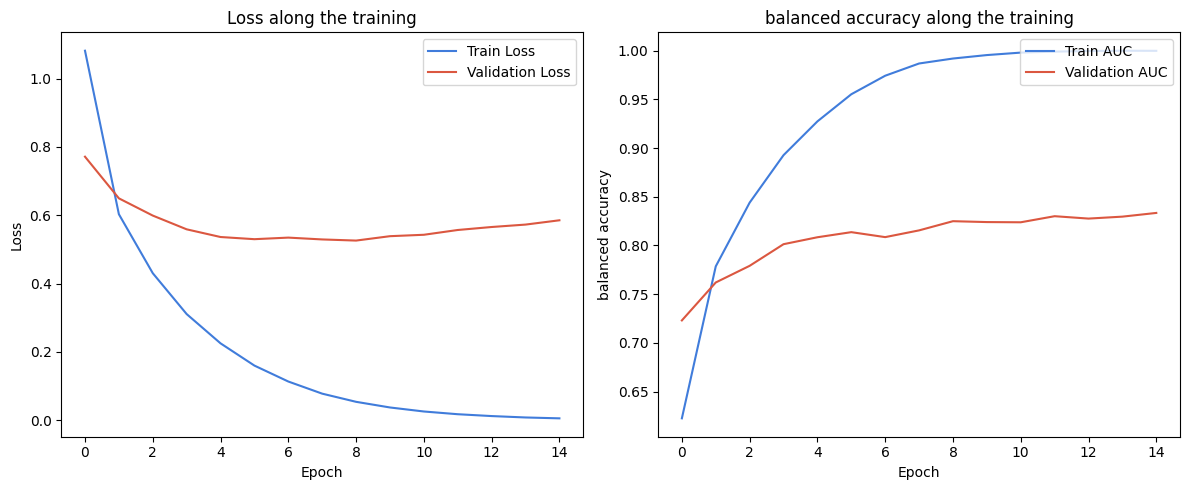

In [171]:
'''
  Foi escolhida a arquitetura dada como exemplo, poís nem uma outra apresentou um
  resultado muito superior. Essa arquitetura vai ser treinada com o otimizador
  Adadelta.
'''

model = Model([784, 384, 100, 11], [ReLU(), ReLU(), Softmax()], initialization_method='he')
opt = AdadeltaOptimizer(model)
trainer = Trainer(model, opt, CrossEntropy())
loss_history, auc_history = trainer.train(15, train_loader, val_loader)
plot_loss_and_auc(loss_history, auc_history)

In [174]:
Y = y_val
Y_pred = model.predict(val_loader)
print(classification_report(Y, Y_pred))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77       487
           1       0.76      0.68      0.72       260
           2       0.72      0.73      0.73       250
           3       0.91      0.93      0.92       275
           4       0.76      0.73      0.75       438
           5       0.77      0.75      0.76       464
           6       0.95      0.96      0.96      1181
           7       0.97      0.98      0.97       427
           8       0.97      0.98      0.98       435
           9       0.77      0.80      0.78       473
          10       0.84      0.84      0.84       616

    accuracy                           0.86      5306
   macro avg       0.84      0.83      0.83      5306
weighted avg       0.85      0.86      0.85      5306



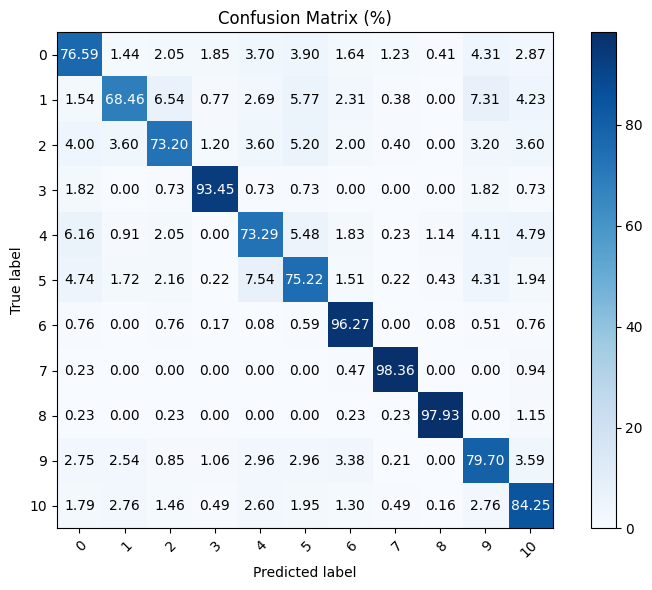

In [175]:
Y = y_val
Y_pred = model.predict(val_loader)
plot_confusion_matrix_percent(Y, Y_pred)

> **Quais são as conclusões? A mudança de otimizador impacta de alguma forma a curva de perda ao longo das épocas? (1-2 parágrafos)**
>
> *Resposta*

>> Para esta questão, utilizamos a arquitetura fornecida como exemplo, juntamente com o otimizador Adadelta. Escolhemos o Adadelta intencionalmente, pois queríamos observar o desempenho de um otimizador que ajusta a taxa de aprendizado automaticamente, eliminando a necessidade de definir um valor inicial. Nos experimentos, o Adadelta apresentou resultados excelentes, permitindo ao modelo superar todos os resultados anteriores, como indicado pela matriz de confusão apresentada.

>>Com Adadelta, o modelo convergiu em muito menos épocas, alcançando alta precisão especialmente nas classes com maior quantidade de dados, como as classes 6, 7 e 8, nas quais conseguiu classificar corretamente mais de 90% das imagens. Além disso, manteve uma taxa de acerto superior a 50% nas demais classes, mostrando uma robustez que não havia sido obtida com outros métodos.

>> O Adadelta provavelmente teve um desempenho superior ao SGD (Stochastic Gradient Descent) devido à sua capacidade de ajustar dinamicamente a taxa de aprendizado durante o treinamento. Diferentemente do SGD, que usa uma taxa de aprendizado fixa, o Adadelta atualiza a taxa de aprendizado com base nos gradientes passados, levando em consideração a magnitude das atualizações anteriores. Esse ajuste dinâmico permite ao modelo se adaptar melhor às diferentes características dos dados, além de evitar os problemas de uma taxa de aprendizado muito alta ou muito baixa, que podem dificultar a convergência ou causar oscilações no treinamento.

>> Além disso, o Adadelta não exige um valor inicial para a taxa de aprendizado, o que o torna mais eficiente em termos de configuração do modelo. O SGD, por outro lado, pode ser sensível à escolha da taxa de aprendizado e, se não for bem ajustada, pode levar a uma convergência mais lenta ou até mesmo à falha em encontrar a solução ótima, algumo que observamos enquanto conduziamos os experimentos


6. (1 ponto) Escolha seu melhor modelo, faça previsões para o conjunto de teste e envie-as para a competição [Redes Neurais – Tarefa #3 de MC886/MO444 2024S2](https://www.kaggle.com/t/f3a05870932d4bb49d59d18cc4a44a2d) no Kaggle. Reporte sua pontuação considerando a tabela de classificação pública. A plataforma calculará automaticamente a métrica de avaliação, a **acurácia balanceada**.

> **Observação:** Não se preocupe apenas com o resultado do seu modelo. O seu resultado no placar não irá influenciar a sua nota nesta atividade :).

In [145]:
Y_pred = model.predict(test_loader)

In [146]:
from google.colab import files
import pandas as pd

x_labels = np.arange(1, len(Y_pred) + 1)
df = pd.DataFrame({'id': x_labels, 'label': Y_pred})

df.to_csv('submission.csv', index=False)

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

> **Quais foram suas conclusões? (1-2 parágrafos)**
>
> **Resposta**
>> O modelo submetido utilizou a arquitetura fornecida como exemplo, treinado com o otimizador Adadelta em pouco menos de 20 épocas. O resultado obtido na competição do Kaggle foi de 0,85 de acurácia balanceada, um desempenho que consideramos bastante interessante, indicando que o modelo foi capaz de classificar de maneira eficaz as 11 classes do dataset. Um ponto digno de destaque é a capacidade do otimizador Adadelta, que possibilitou um desempenho significativamente superior ao dos outros modelos testados, treinando em um número muito menor de épocas.


---

## Prazo

**Prazo de entrega:** 06 de Novembro, quarta-feira, 23:59.

**Política de penalidades por envio atrasado:** Você não está sendo encorajada(o) a submeter o trabalho após a data de submissão. Entretanto, caso isso aconteça, a nota será penalizada da seguinte forma:
- 07 de Novembro, 23:59: nota * 0,75
- 08 de Novembro, 23:59: nota * 0,5
- 09 de Novembro, 23:59: nota * 0,25

## Envio

No Google Classroom, envie seu Jupyter Notebook, no formato `RA1_RA2_2024s2_mc886mo444_trabalho_03.ipynb`.

**Esta atividade NÃO é individual, deve ser realizada em dupla (grupo de duas pessoas).**